In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Read in data

In [1]:
# Read in data 
root_dir = Path().resolve().parents[1]
data_dir = root_dir / "data" / "02-clean"

upem_met_fpath = data_dir / "sci-upem-clean-2005-2010.csv"
upem_lcl_fpath = data_dir / "goes-extracted" / "upem-lcl.csv"

upem_met = pd.read_csv(upem_met_fpath, index_col='time (PST)').drop('Unnamed: 0', axis=1)
upem_lcl = pd.read_csv(upem_lcl_fpath, index_col='time-PDT').drop('Unnamed: 0', axis=1)

# Preprocess
upem_met.index = pd.to_datetime(upem_met.index)
upem_lcl.index = pd.to_datetime(upem_lcl.index)
upem_lcl.index = upem_lcl.index - pd.Timedelta(hours=1) # Change PDT to PST
upem_lcl.index.name = 'time (PST)'

# Join the dataframes
df = pd.concat([upem_lcl, upem_met], join='inner', axis=1)

# Create binary variables
df['fog-binary'] = df['fog'].apply(lambda x: 1 if x > 0 else 0)
df['cldalb-binary'] =df['cldalb'].apply(lambda x: 1 if x > 8.5 else 0)
df.head(2)

NameError: name 'Path' is not defined

In [ ]:
print(df.isna().sum())
df.dropna(inplace=True)

cldalb                    31
fog                        0
air temperature (C)        0
relative humidity (%)      0
wind speed (m/s)           0
wind gust (m/s)            0
wind direction (deg)       0
rain (mm)                  0
solar radiation (kwm2)     0
fog tips                   0
fog-binary                 0
cldalb-binary              0
dtype: int64


In [ ]:
print(df.index.min())
print(df.index.max())

2006-05-01 06:00:00
2009-09-30 17:30:00


In [ ]:
# How many fog observations are there? 
df['fog-binary'].value_counts()

fog-binary
0    12085
1      279
Name: count, dtype: int64

In [ ]:
df['cldalb-binary'].value_counts()

cldalb-binary
0    6822
1    5542
Name: count, dtype: int64

# EDA Plots

<Axes: xlabel='relative humidity (%)'>

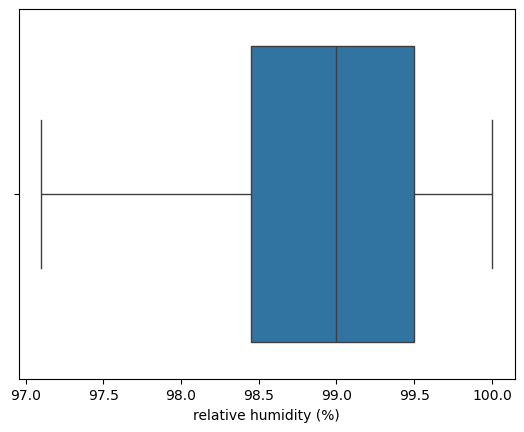

In [ ]:
## What's the range of RH for fog drip? 
df_subset = df.loc[df['fog tips'] > 1]
sns.boxplot(data=df_subset,
            x='relative humidity (%)')

<Axes: xlabel='relative humidity (%)'>

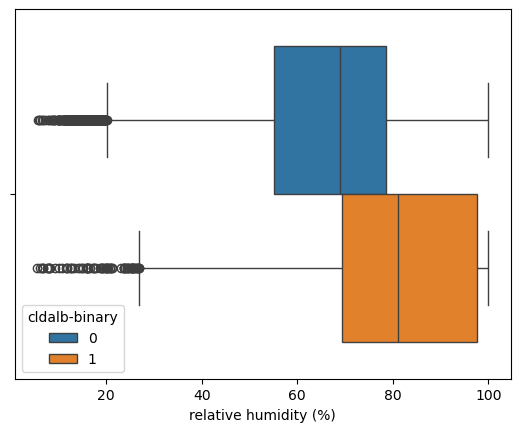

In [ ]:
sns.boxplot(data=df,
            x='relative humidity (%)',
            hue='cldalb-binary')

In [ ]:
# Create an RH fog variable
df['rh-fog'] = df['relative humidity (%)'].apply(lambda x: 1 if x > 97 else 0)
df['rh-fog'].value_counts()

rh-fog
0    10468
1     1896
Name: count, dtype: int64

## Box Plots

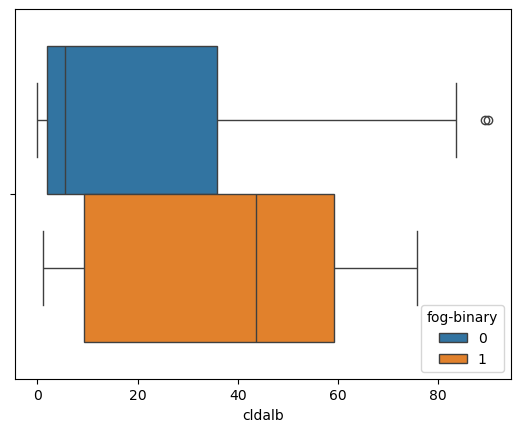

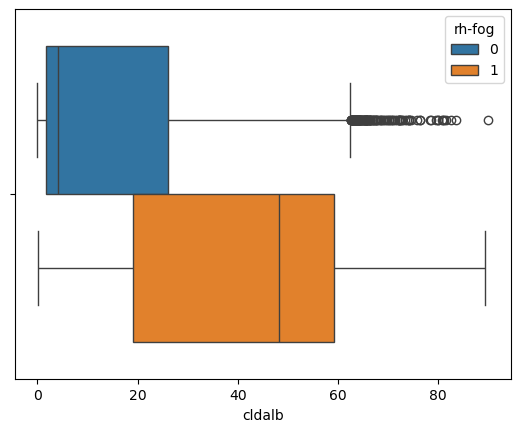

In [ ]:
# Quick check 
sns.boxplot(data=df,
           x='cldalb',
           hue='fog-binary')
plt.show()

sns.boxplot(data=df,
           x='cldalb',
           hue='rh-fog')
plt.show()

## Histogram

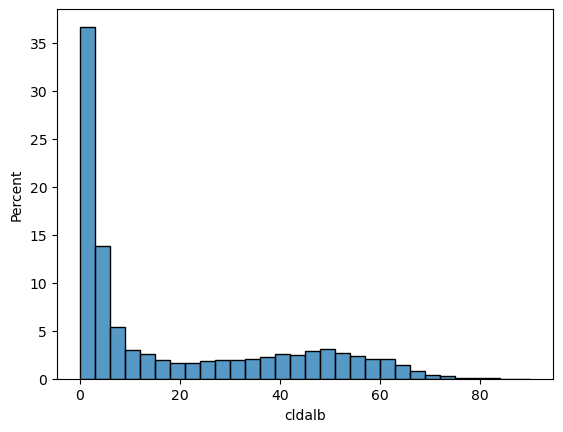

In [ ]:
sns.histplot(data=df,
             x='cldalb',
             stat='percent')
plt.show()

## Correlation Matrix

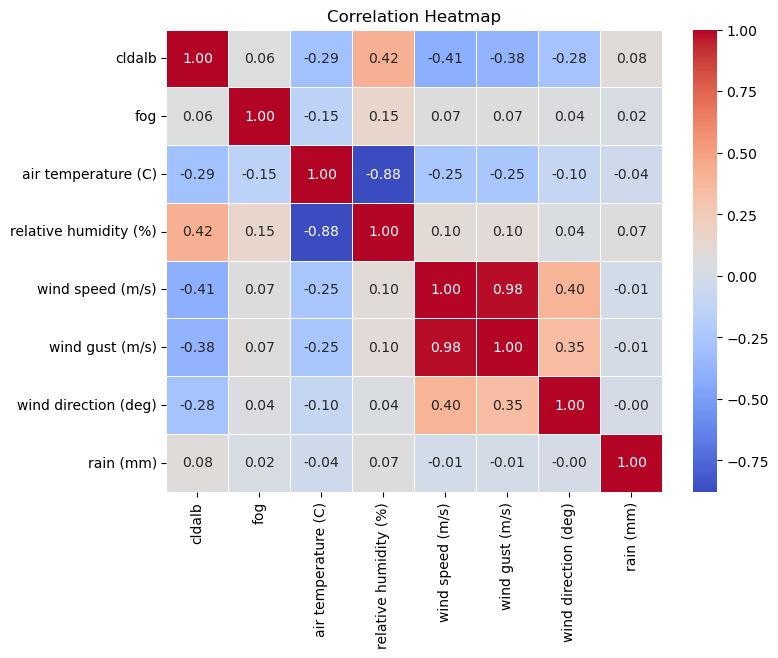

In [ ]:
# Calculate the correlation matrix
corr_matrix = df[['cldalb', 'fog', 'air temperature (C)', 'relative humidity (%)',
       'wind speed (m/s)', 'wind gust (m/s)', 'wind direction (deg)',
       'rain (mm)']].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Fog/LCL Agreeance

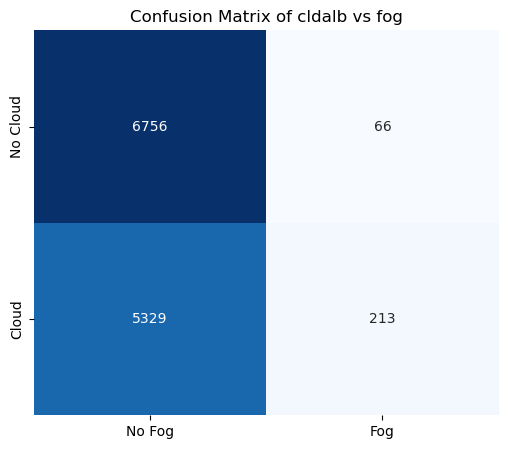

In [ ]:
cm = confusion_matrix(df['cldalb-binary'], df['fog-binary'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog', 'Fog'], yticklabels=['No Cloud', 'Cloud'])

# Add labels and title
plt.title('Confusion Matrix of cldalb vs fog')

# Show the plot
plt.show()

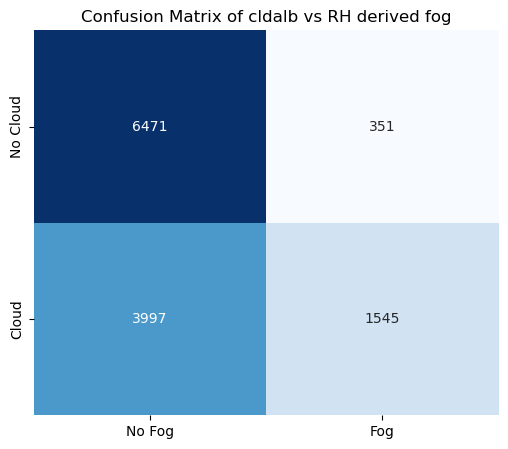

In [ ]:
cm = confusion_matrix(df['cldalb-binary'], df['rh-fog'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Fog', 'Fog'], yticklabels=['No Cloud', 'Cloud'])

# Add labels and title
plt.title('Confusion Matrix of cldalb vs RH derived fog')

# Show the plot
plt.show()

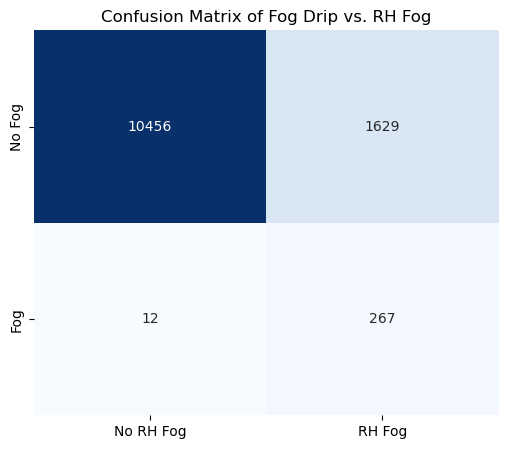

In [ ]:
cm = confusion_matrix(df['fog-binary'], df['rh-fog'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No RH Fog', 'RH Fog'], yticklabels=['No Fog', 'Fog'])

# Add labels and title
plt.title('Confusion Matrix of Fog Drip vs. RH Fog')

# Show the plot
plt.show()

## Linear Regression

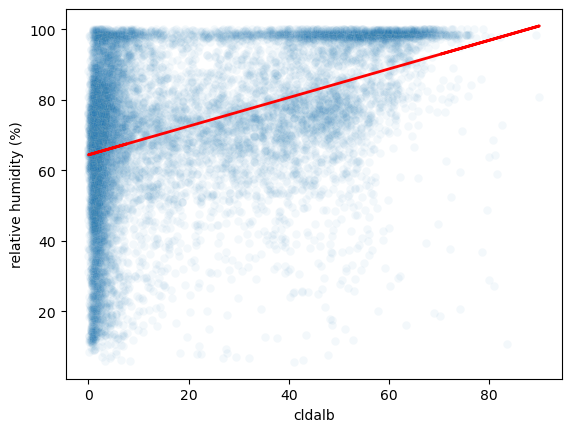

Intercept: [64.37228671]
Slope (Coefficient for cldalb): [0.40636231]
R-squared: 0.17601569688674268


In [ ]:
model = LinearRegression()
model.fit(df[['cldalb']], df[['relative humidity (%)']])
y_pred = model.predict(df[['cldalb']])

# Create a seaborn scatterplot
sns.scatterplot(x='cldalb', y='relative humidity (%)', alpha=0.05, data=df)

# Plot the regression line
plt.plot(df['cldalb'], y_pred, color='red', linewidth=2)
plt.show()


# Get the regression results
intercept = model.intercept_
slope = model.coef_[0]  # Since we have only one feature, get the first coefficient
r_squared = model.score(df[['cldalb']], df[['relative humidity (%)']])  # R-squared value

# Print the results
print(f"Intercept: {intercept}")
print(f"Slope (Coefficient for cldalb): {slope}")
print(f"R-squared: {r_squared}")